##📊 Notebook Description:  
Analysis of parameters obteins by the CropReporter Over Time by Treatment Group
This notebook performs a temporal analysis of any parameter (see examples parameters below) across different experimental groups and dates. In this example the groups represent combinations of treatments related to movement, salt presence, and water condition (e.g., MinMove_NoSalt_WW, MinMove_Salt_WW, etc.).

###🔍 Key Features:
Boxplots by Date and Group:
For each date, the notebook generates a boxplot showing the distribution of chosen parameter for each treatment group. This allows for a visual comparison of growth patterns or treatment effects over time.

Group Comparison with Statistical Testing:
Each subplot includes a p-value indicating the result of a statistical test (likely ANOVA) comparing groups for that specific date. This helps identify which timepoints show significant differences between treatments.

Highlighting Significant Differences:
Dates with statistically significant differences (p-value < 0.05) are visually highlighted with a yellow background, making it easy to spot key moments in the experiment when treatments began to diverge.


Gaps in boxplot content suggest days with missing data of that particular parameter (Remember not always we measure everything)


###To use this notebook with your data, you need to edit the following:
- Select input file, two options: NPEC facilities output file (Azure) or CropReporter software file (Vincent)
- File path
- The number of rows in your csv that conteins metadata (in which raw you have your columns names)
- The maximum number of experimental factors, in this case, we have three: Movement, Salt, and irrigation (genotype is not considered an experimental factor in this setup).
-The parameter that you want to check, example NDVI
-The output path and file name


Main parameters:
Fv/Fm, dFv/Fm, Fq'/Fm', dFq/Fm, rETR, NPQ, qP, qN, qL, фno, фnpq, Red, Green, Blue, Hue, Saturation, Value, NDVI, ChlIdx, AriIdx, SpcGrn, FarRed, Nir, Rfd

### 📁 File Naming Convention and Experimental Factor Setup

To ensure compatibility with downstream parsing, **always format your file names as follows**:


### 🔍 Filename Structure
Example:  
HDR_133_NPEC51.AH1.Brioso.MaxMove_NoSalt_WW.1_2093_20250320_161314.INF


133- `<ExpNumber>`   
NPEC51- `<NPECNumber>`   
AH1- `<TrayPosition>`  
Brioso- `<Genotype>` – The name of the plant genotype (e.g., Brioso)  
  MaxMove- `<ExpFactor1_2_3>` – Encoded categorical experimental conditions  
  NoSalt-`<ExpFactor1_2_3>` – Encoded categorical experimental conditions  
  WW-`<ExpFactor1_2_3>` – Encoded categorical experimental conditions  
  1- `<PlantNumber>` – Identifier for the plant (e.g., 1)  
  2093- `<Treatment indentifier>`   
  20250320- `<Date>` – In `YYYYMMDD` format  
  161314- `<Time>` – In `HHMMSS` format  
    
      
      In our expreriment we have
      exp_factor1 = 'MoveType' -> 'MinMove', 'MaxMove'  
      exp_factor2 = 'SaltStatus' -> 'NoSalt', 'Salt'  
      exp_factor3 = 'Irrigation'->  'WW', 'DR'




##Insert your variables

In [129]:

SOURCE = 'PHENOVATION' #Complete with 'PHENOVATION' or 'NPEC'

#Select input file, two options: NPEC facilities output file (Azure) or CropReporter software file (Vincent) (Analyse one file at the time)
# Path for NPEC example: '/content/drive/MyDrive/NPEC_notebooks/CropReporter/cropreporter_traits_table.csv'
# Path for PHENOVATION example: '/content/drive/MyDrive/NPEC_notebooks/CropReporter/Data_Tom.csv'

PATH = '/content/drive/MyDrive/NPEC_notebooks/CropReporter/Data_Tom.csv'

#The number of rows in your csv that conteins metadata (in which raw you have your columns names)
HEADER_ROWS = 118  #PHENOVATION example: 118 , NPEC = 0

#The maximum number of experimental factors, in this case, we have three: Movement, Salt, and irrigation (genotype is not considered an experimental factor in this setup).
EXPfactors = 3

#The parameter that you want to check, example NDVI
#(To know more parameters in yor file, you can explore the file with Excel and check your columns names, or use this netobok sction: checking columns)
PARAM =  'phiPSII' #PHENOVATION examples: 'NDVI' 'phiPSII' 'FvFm' 'ChlIdx' 'AriIdx'  NPEC example: 'PmlFvFmMedian'

#The output path and file name
OUTPUTfileNAME = 'Sofia_checkings'
OUTPUTdir = '/content/drive/MyDrive/NPEC_notebooks/CropReporter/Results'

##Conecting to your Google Drive & Loading libraries

In [130]:
from google.colab import drive

#Conect your gmail drive to the netbook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

import matplotlib.patches as patches
from scipy.stats import f_oneway

## Checking columns names

In [132]:
# Load and print based on SOURCE
if SOURCE == 'NPEC':
  tables = pd.read_csv(PATH)
  print(f"Loaded NPEC file with {tables.shape[1]} columns:\n")
  for col in tables.columns:
    print(col)
else:
  print("NPEC source not selected.")

if SOURCE == 'PHENOVATION':
  tables = pd.read_csv(PATH, sep='\t', skiprows=HEADER_ROWS, encoding='utf-16-le', engine='python')
  tables.replace(-1, np.nan, inplace=True)
  tables.rename(columns={'Fv/Fm': 'FvFm', "Fq'/Fm'": 'phiPSII'}, inplace=True)
  print(f"Loaded PHENOVATION file with {tables.shape[1]} columns:\n")
  for col in tables.columns:
    print(col)
else:
  print("PHENOVATION source not selected.")


NPEC source not selected.
Loaded PHENOVATION file with 253 columns:

File
Date
Time
Obj.No
nTmPam
Obj.Size
Obj.Xc
Obj.Yc
dFv/Fm
s.d.
F0
s.d..1
Fj
s.d..2
Fi
s.d..3
Fm
s.d..4
1-Fj/Fm
s.d..5
1-Fi/Fm
s.d..6
FvFm
s.d..7
IC-Area
s.d..8
IC-Area/Fv
s.d..9
PI
s.d..10
Fv/fm I (px)
Fv/fm I (%)
Fv/fm II (px)
Fv/fm II (%)
Fv/fm III (px)
Fv/fm III (%)
Fv/fm IV (px)
Fv/fm IV (%)
Fv/fm V (px)
Fv/fm V (%)
dFq/Fm
s.d..11
Fs'
s.d..12
Fm'
s.d..13
phiPSII
s.d..14
rETR
s.d..15
Fq'/fm' I (px)
Fq'/fm' I (%)
Fq'/fm' II (px)
Fq'/fm' II (%)
Fq'/fm' III (px)
Fq'/fm' III (%)
Fq'/fm' IV (px)
Fq'/fm' IV (%)
Fq'/fm' V (px)
Fq'/fm' V (%)
Etr I (px)
Etr I (%)
Etr II (px)
Etr II (%)
Etr III (px)
Etr III (%)
Etr IV (px)
Etr IV (%)
Etr V (px)
Etr V (%)
dRfd
s.d..16
RfdFm
s.d..17
RfdFt
s.d..18
Rfd
s.d..19
Rfd I (px)
Rfd I (%)
Rfd II (px)
Rfd II (%)
Rfd III (px)
Rfd III (%)
Rfd IV (px)
Rfd IV (%)
Rfd V (px)
Rfd V (%)
NPQ
s.d..20
F0'
s.d..21
qP
s.d..22
qN
s.d..23
qL
s.d..24
qE
s.d..25
qI
s.d..26
фno
s.d..27
фnpq
s.d..28
npq(

##Generating extra columns

In [133]:
def extract_metadata(df, source0):
    """
    Extracts genotype, up to N experimental factors, plant number, and combined plant group from filenames.

    Args:
        df (pd.DataFrame): DataFrame with a column containing filenames
        source0 (str): Either 'NPEC' or 'PHENOVATION' to determine parsing logic

    Returns:
        DataFrame with columns: Genotype, ExpFactor1...N, PlantNumber, PlantGroup
    """
    if source0 == 'NPEC':
        file_col = 'DataMatrix'
        parts = df[file_col].str.split(r'[._]', expand=True)
        new_cols = {'Genotype': parts[3], 'PlantNumber': parts[4 + EXPfactors]}
        for i in range(EXPfactors):
            new_cols[f'ExpFactor{i+1}'] = parts[4 + i]
        new_df = pd.DataFrame(new_cols, index=df.index)
        expfactor_cols = [f'ExpFactor{i+1}' for i in range(EXPfactors)]
        new_df['PlantGroup'] = new_df[expfactor_cols].astype(str).agg('_'.join, axis=1)
        new_df['Date'] = pd.to_datetime(df['DateTime'].str.slice(0,8), format='%Y%m%d').dt.date
        new_df['Time'] = pd.to_datetime(df['DateTime'].str.slice(9,15), format='%H%M%S').dt.time
        return pd.concat([df, new_df], axis=1).copy()

    elif source0 == 'PHENOVATION':
        file_col = 'File'
        parts = df[file_col].str.split(r'[._]', expand=True)
        new_cols = {'Genotype': parts[4], 'PlantNumber': parts[5 + EXPfactors]}
        for i in range(EXPfactors):
            new_cols[f'ExpFactor{i+1}'] = parts[5 + i]
        new_df = pd.DataFrame(new_cols, index=df.index)
        expfactor_cols = [f'ExpFactor{i+1}' for i in range(EXPfactors)]
        new_df['PlantGroup'] = new_df[expfactor_cols].astype(str).agg('_'.join, axis=1)
        return pd.concat([df, new_df], axis=1).copy()

In [136]:
table0 = extract_metadata(tables, SOURCE) ### Complete the number of experimental factors in your file_name
print(table0)

                                                   File      Date   Time  \
0     HDR_133_NPEC51.AH1.Brioso.MaxMove_NoSalt_WW.1_...  20250320  16:13   
1     HDR_133_NPEC51.AH11.Brioso.MaxMove_NoSalt_WW.6...  20250320  17:28   
2     HDR_133_NPEC51.AH13.Brioso.MaxMove_NoSalt_WW.7...  20250320  17:41   
3     HDR_133_NPEC51.AH15.Brioso.MaxMove_NoSalt_WW.8...  20250320  17:53   
4     HDR_133_NPEC51.AH17.Brioso.MaxMove_NoSalt_WW.9...  20250320  18:06   
...                                                 ...       ...    ...   
1705  HDR_133_NPEC51.AG4.Brioso.MinMove_NoSalt_DR.2_...  20250419  19:04   
1706  HDR_133_NPEC51.AG6.Brioso.MinMove_NoSalt_DR.3_...  20250419  00:24   
1707  HDR_133_NPEC51.AG6.Brioso.MinMove_NoSalt_DR.3_...  20250419  19:07   
1708  HDR_133_NPEC51.AG8.Brioso.MinMove_NoSalt_DR.4_...  20250419  00:31   
1709  HDR_133_NPEC51.AG8.Brioso.MinMove_NoSalt_DR.4_...  20250419  19:10   

     Obj.No  nTmPam  Obj.Size  Obj.Xc  Obj.Yc  dFv/Fm  s.d.  ...  s.d..53  \
0       Al

###Load functions

In [137]:
#Definition class, no need to edit anything here, only run

class ZxyAnalyzer:
    def __init__(self, table, zxy_var, group_col='PlantGroup', date_col='Date'):
        self.table = table.copy()
        self.zxy = zxy_var
        self.group_col = group_col
        self.date_col = date_col
        self.target_dates = self.table[date_col].unique()
        self.target_groups = self.table[group_col].unique()
        self.lower_whisker = None
        self.upper_whisker = None

    def compute_quartiles(self):
        all_values = self.table[self.zxy].values
        clean_values = all_values[np.isfinite(all_values)]

        Q1 = np.percentile(clean_values, 25)
        Q3 = np.percentile(clean_values, 75)
        IQR = Q3 - Q1
        self.lower_whisker = max(clean_values.min(), Q1 - 1.5 * IQR)
        self.upper_whisker = min(clean_values.max(), Q3 + 1.5 * IQR)

        print(f"Q1={Q1:.3f}, Q3={Q3:.3f}, lower_whisker={self.lower_whisker:.3f}, upper_whisker={self.upper_whisker:.3f}")

    def plot_boxgrid(self, n_cols=3, figsize=(12, 15), save_path=None):
        if self.lower_whisker is None or self.upper_whisker is None:
            self.compute_quartiles()

        n_dates = len(self.target_dates)
        n_rows = math.ceil(n_dates / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharey=True)
        axes = axes.flatten()

        for i, target_date in enumerate(self.target_dates):
            ax = axes[i]
            filtered = self.table[
                (self.table[self.date_col] == target_date) &
                (self.table[self.group_col].isin(self.target_groups))
            ].copy()
            filtered = filtered[filtered[self.zxy].notna()]

            # Prepare for ANOVA
            groups_data = [group[self.zxy].values for _, group in filtered.groupby(self.group_col) if len(group) > 1]

            if len(groups_data) >= 2:
                anova_res = f_oneway(*groups_data)
                p_value = anova_res.pvalue
            else:
                p_value = 1  # Not enough data

            # Highlight significant p-values
            ax.set_facecolor('yellow' if p_value < 0.05 else 'white')

            sns.boxplot(data=filtered, x=self.group_col, y=self.zxy, color='lightgray', ax=ax)
            sns.stripplot(data=filtered, x=self.group_col, y=self.zxy, color='black', size=4, jitter=True, ax=ax)

            ax.set_title(f'{target_date} (p={p_value:.3f})', fontsize=10)
            ax.set_xlabel('')
            ax.set_ylabel(self.zxy if i % n_cols == 0 else '')
            ax.tick_params(axis='x', rotation=45)
            ax.set_ylim(self.lower_whisker - self.lower_whisker * 0.2,
                        self.upper_whisker + self.upper_whisker * 0.2)
            ax.grid(False)

        # Hide any unused subplots
        for j in range(len(self.target_dates), n_rows * n_cols):
            fig.delaxes(axes[j])

        plt.suptitle(f'Boxplots of {self.zxy} by Group and Date', fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if save_path:
            plt.savefig(save_path, dpi=300)
        else:
            plt.show()

    def get_anova_results(self):
        results = []
        for date in self.target_dates:
            filtered = self.table[
                (self.table[self.date_col] == date) &
                (self.table[self.group_col].isin(self.target_groups))
            ].copy()
            present_groups = filtered[self.group_col].unique().tolist()
            filtered = filtered[filtered[self.zxy].notna()]
            groups_data = [group[self.zxy].values for _, group in filtered.groupby(self.group_col) if len(group) > 1]

            if len(groups_data) >= 2:
                anova_res = f_oneway(*groups_data)
                p_value = anova_res.pvalue
            else:
                p_value = np.nan

            results.append({'Date': date, 'p_value': p_value, 'Groups': present_groups})
        return pd.DataFrame(results)


##See results

In [138]:
analyzer = ZxyAnalyzer(table0, PARAM)
analyzer.compute_quartiles()


Q1=2.741, Q3=3.662, lower_whisker=1.359, upper_whisker=5.044


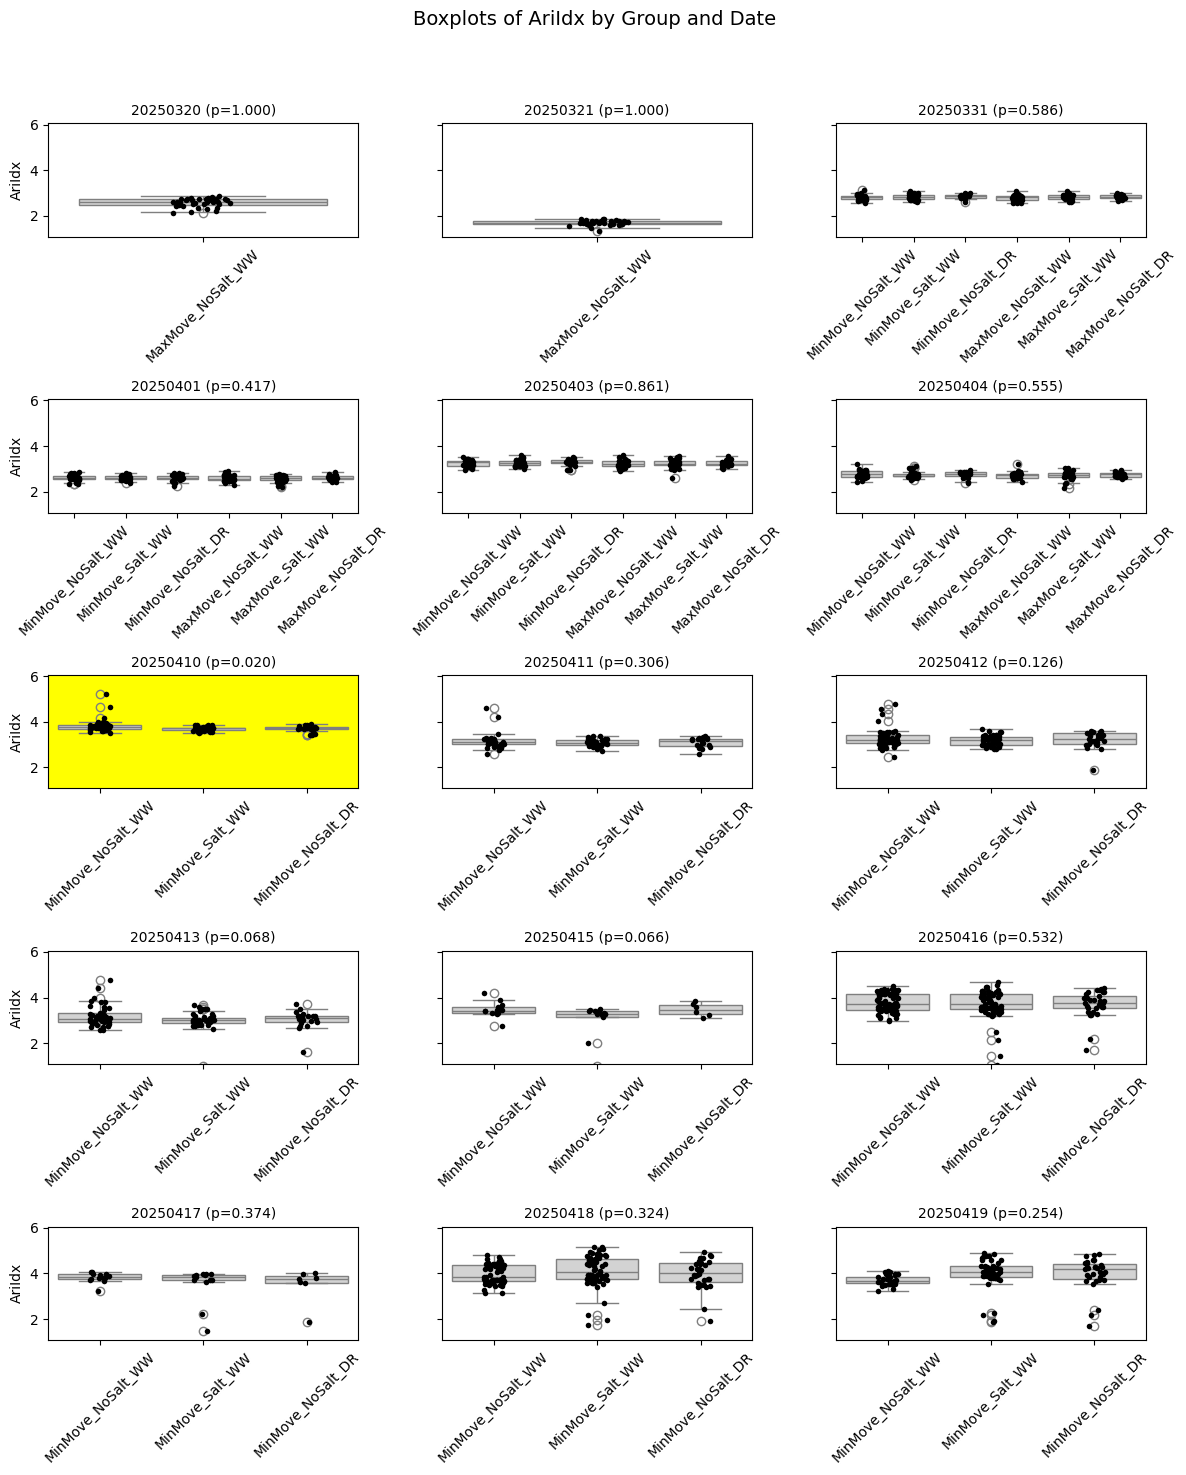

In [139]:
analyzer.plot_boxgrid(n_cols=3, figsize=(12, 15), save_path= f'{OUTPUTdir}/{OUTPUTfileNAME}_{PARAM}.png' ) #remember change your path and file name


In [140]:
## Export Anova results
anova_df = analyzer.get_anova_results()
anova_df.to_csv(f'{OUTPUTdir}/{OUTPUTfileNAME}_{PARAM}.csv', index=False) #remember change your path and file name

#print(anova_df)

#Bonus Code

##If ANOVA is significant, you can perform a post hoc test such as Tukey's HSD — for example, on phiPSII data from April 18, 2025 with PHENOVATION dataset.

In [105]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Filter and clean
one_day_data = table0[table0['Date'] == 20250418]

one_day_data = one_day_data.dropna(subset=['phiPSII'])

# Final check: Are there at least 2 observations per group?
print(one_day_data.groupby('PlantGroup').size())

# Tukey HSD
tukey_result = pairwise_tukeyhsd(
    endog=one_day_data['phiPSII'],
    groups=one_day_data['PlantGroup'],
    alpha=0.05
)

# Output
print(tukey_result.summary())

######Result########
#All three pairwise comparisons are statistically significant (reject = True).
#This means plant group (i.e. treatment or condition) has a clear effect on "Fq'/Fm'" on that date.
#MinMove_NoSalt_DR < MinMove_Salt_WW < MinMove_NoSalt_WW


PlantGroup
MinMove_NoSalt_DR    17
MinMove_NoSalt_WW    35
MinMove_Salt_WW      34
dtype: int64
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
MinMove_NoSalt_DR MinMove_NoSalt_WW  -0.0885    0.0 -0.1198 -0.0572   True
MinMove_NoSalt_DR   MinMove_Salt_WW  -0.0542 0.0003 -0.0857 -0.0227   True
MinMove_NoSalt_WW   MinMove_Salt_WW   0.0343 0.0054  0.0087  0.0598   True
--------------------------------------------------------------------------


##Would you like to calculate your own index?

In [ ]:
# You can also calculate your own vegetation indices—for example, a Green Index—
# using the raw R, G, B channel data from the images.
# A simple example of a Green Index is:
#    Green Index = G / (R + G + B)
# This can help highlight plant health or canopy cover from RGB images.

table0['myGreenInd'] = table0['Green'] / (table0['Blue'] + table0['Green']  + table0['Red'] )

In [ ]:
analyzer = ZxyAnalyzer(table0, zxy_var='myGreenInd')
analyzer.compute_quartiles()
analyzer.plot_boxgrid(n_cols=3, figsize=(12, 15), save_path= f'{OUTPUTdir}/my_plot_myGreenInd.png' )
